#1. Ordering coordinates clockwise with Python and OpenCV
https://www.pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/

1st of 3 part series on calculating the size of objecs in images along with measuring the distances between them.

USAGE: python   
order_coordinates.py

In [38]:
%tensorflow_version 1.x

In [39]:
# import the necessary packages
from __future__ import print_function
from imutils import perspective
from imutils import contours
from google.colab.patches import cv2_imshow

import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt


###The original (flawed) method    
the original 4 point getPerspectiveTransform method


In [44]:
def order_points_old(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


###"Better method"로 정의한 alternative method


In [46]:
#A better method to order coordinates clockwise    

# import the necessary packages
from scipy.spatial import distance as dist   
import numpy as np   
import cv2   

def order_points(pts):   
  #sort the points based on their x-coordinates   
  xSorted = pts[np.argsor(pts[:,0]), :]   

  #grab the left-most and right-most points from the sorted x-coordinate points   
  leftMost = xSorted[:2, :]
  rightMost = xSorted[2:, :]

  #now, sort the left-most coordinates according to their y-coordinates 
  #so we can grab the top-left and bottom-left points, respectively   
  leftMost = leftMost[np.argsor(leftMost[:, 1]), :]   
  (tl, bl) = leftMost   

  #now that we have the top-left coordinate, use it as an anchor 
  #to calculate the Euclidean distance between the top-left and right-most points; 
  #by the Pythagorean theorem, the point with the largest distance will be our bottom-right point   
  D=dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]   
  (br, tr) = rightMost[np.argsor(D)[::-1], :]

  #return the corrdinates in top-left, top-right, bottom-right, and bottom-left order   
  return np.array([tl, tr, br, bl], dtype="float32")

In [50]:
# construct the argument parse and parse the arguments
#original implementation과 new order coordinate method가 둘다 필요한지를 판단하기 위해

#EunAh: argparse가 정의가 잘못되었는지 자꾸 에러를 만들어냄

ap = argparse.ArgumentParser()
ap.add_argument("-n", "-new", type=int, default=-1,
	help="whether or not the new order points should be used")
args = vars(ap.parse_args())


#load our input image, convert it to grayscale, and blur it slightly

image = cv2.imread("example.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("converted to grayscale")
cv2_imshow(gray)

gray = cv2.GaussianBlur(gray, (7, 7), 0)
print("blurred")
cv2_imshow(gray)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
print("canny")
cv2_imshow(edged)

edged = cv2.dilate(edged, None, iterations=1)
print("dilated")
cv2_imshow(edged)

edged = cv2.erode(edged, None, iterations=1)
print("eroded")
cv2_imshow(edged)

#여기까지 해서 edge map의 outline 얻음

usage: ipykernel_launcher.py [-h] [-n N]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-69f129ae-3e2c-4125-bdf3-f1b9a6ab1c6c.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#EunAh: RETR_EXTERNAL: (모든 윤곽선이 아닌)외곽 윤곽선만 검출, 계층 구조는 구성하지 않는 Contour Retrieveal Mode
#EunAh: CHAIN_APPROX_SIMPLE: 어떤 이미지에서 contour를 찾을 때 모든 점을 얻는 것이 아니라, 직선의 양 끝점 2개만 얻음
#(CHAIN_APPROX_NONE은 contour의 모든 점을 취함)

# sort the contours from left-to-right and initialize the bounding box
# point colors
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))

In [36]:
# loop over the contours individually
for (i, c) in enumerate(cnts):
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue

	# compute the rotated bounding box of the contour, then
	# draw the contours
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
 
 	# show the original coordinates
	print("Object #{}:".format(i + 1))
	print(box)

Object #1:
[[ 42 236]
 [ 42 190]
 [ 90 190]
 [ 90 236]]
Object #2:
[[192 192]
 [171  94]
 [342  59]
 [362 157]]
Object #3:
[[348 229]
 [348 183]
 [395 183]
 [395 229]]
Object #4:
[[400 383]
 [377 258]
 [489 237]
 [512 363]]
Object #5:
[[495 211]
 [392 161]
 [450  42]
 [553  92]]
Object #6:
[[520 255]
 [491 226]
 [520 197]
 [549 226]]


In [51]:
#argumentParser에서 시작된 에러가 여기서 지속되는듯 함... 

# order the points in the contour such that they appear
# in top-left, top-right, bottom-right, and bottom-left
# order, then draw the outline of the rotated bounding
# box
rect = order_points_old(box)

# check to see if the new method should be used for
# ordering the coordinates
if args["new"] > 0:
	rect = perspective.order_points(box)

# show the re-ordered coordinates
print(rect.astype("int"))
print("")

NameError: ignored

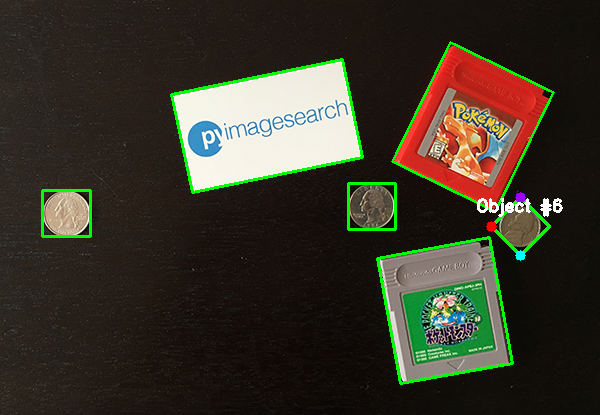

-1

In [55]:
	# loop over the original points and draw them
	for ((x, y), color) in zip(rect, colors):
		cv2.circle(image, (int(x), int(y)), 5, color, -1)
	
	# draw the object num at the top-left corner
	cv2.putText(image, "Object #{}".format(i + 1),
		(int(rect[0][0] - 15), int(rect[0][1] - 15)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)
 
# show the image
#cv2.imshow("Image", image) #버전과 맞지 않는 형식이라 아래 명령어로 수정
cv2_imshow(image)
cv2.waitKey(0)

#2. Measuring size of objects in an image with OpenCV

2nd of 3 part series on calculating the size of objecs in images along with measuring the distances between them.

Import library & modules

In [ ]:
# USAGE
# python object_size.py --image images/example_01.png --width 0.955
# python object_size.py --image images/example_02.png --width 0.955
# python object_size.py --image images/example_03.png --width 3.5

# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())

In [ ]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

In [ ]:
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

In [ ]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

In [ ]:
# loop over the contours individually
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue

	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")

	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)

	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

	# compute the Euclidean distance between the midpoints
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / args["width"]

	# compute the size of the object
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)

	# show the output image
	cv2.imshow("Image", orig)
	cv2.waitKey(0)

#3. Measuring distance between objects in an image and OpenCV

3rd of 3 part series on calculating the size of objecs in images along with measuring the distances between them.

## USAGE
### python distance_between.py --image images/example_01.png --width 0.955
### python distance_between.py --image images/example_02.png --width 0.955
### python distance_between.py --image images/example_03.png --width 3.5

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())

# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and, then initialize the
# distance colors and reference object
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (0, 165, 255), (255, 255, 0),
	(255, 0, 255))
refObj = None

# loop over the contours individually
for c in cnts:
	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue

	# compute the rotated bounding box of the contour
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")

	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)

	# compute the center of the bounding box
	cX = np.average(box[:, 0])
	cY = np.average(box[:, 1])

	# if this is the first contour we are examining (i.e.,
	# the left-most contour), we presume this is the
	# reference object
	if refObj is None:
		# unpack the ordered bounding box, then compute the
		# midpoint between the top-left and top-right points,
		# followed by the midpoint between the top-right and
		# bottom-right
		(tl, tr, br, bl) = box
		(tlblX, tlblY) = midpoint(tl, bl)
		(trbrX, trbrY) = midpoint(tr, br)

		# compute the Euclidean distance between the midpoints,
		# then construct the reference object
		D = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
		refObj = (box, (cX, cY), D / args["width"])
		continue

	# draw the contours on the image
	orig = image.copy()
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
	cv2.drawContours(orig, [refObj[0].astype("int")], -1, (0, 255, 0), 2)

	# stack the reference coordinates and the object coordinates
	# to include the object center
	refCoords = np.vstack([refObj[0], refObj[1]])
	objCoords = np.vstack([box, (cX, cY)])

	# loop over the original points
	for ((xA, yA), (xB, yB), color) in zip(refCoords, objCoords, colors):
		# draw circles corresponding to the current points and
		# connect them with a line
		cv2.circle(orig, (int(xA), int(yA)), 5, color, -1)
		cv2.circle(orig, (int(xB), int(yB)), 5, color, -1)
		cv2.line(orig, (int(xA), int(yA)), (int(xB), int(yB)),
			color, 2)

		# compute the Euclidean distance between the coordinates,
		# and then convert the distance in pixels to distance in
		# units
		D = dist.euclidean((xA, yA), (xB, yB)) / refObj[2]
		(mX, mY) = midpoint((xA, yA), (xB, yB))
		cv2.putText(orig, "{:.1f}in".format(D), (int(mX), int(mY - 10)),
			cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

		# show the output image
		cv2.imshow("Image", orig)
		cv2.waitKey(0)